In [1]:
import itertools as itt
import pathlib as pl
from configparser import ConfigParser
from math import factorial

import joblib as jl
import numpy as np
import pandas as pd
import scipy.stats as sst
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from src.root_path import config_path, root_path
from src.utils.tools import decimate_xy
from src.visualization.interactive import plot_raw_pair, plot_pupil_so_effects
from src.visualization.palette import *

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2023-05-24 174916.log


 code copied over from "220810_pupil_differences_memory_efficient.ipynb" and cleaned
# First order effects
how pupil size is correlated with firing rate

In [2]:
# New firing rates, the file is a misnomer, it has not deltas
fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220808_pupil_fr_by_instance'
first_ord_DF = jl.load(fr_DF_file
                       ).query("part == 'probe' and chunk == 'full'"
                               # " and pupil != 'full'"
                               ).drop(columns=['chunk', 'part', 'metric']
                                      ).reset_index(drop=True)

first_ord_DF = first_ord_DF.groupby(['id', 'site', 'probe', 'pupil'],
                                    observed=True, dropna=True).agg(value=('value', np.nanmean)).reset_index()

print(first_ord_DF.shape)
first_ord_DF.head()

(35316, 5)


,id,site,probe,pupil,value
0,CRD003b-02-2,CRD003b,1,small,0.011436
1,CRD003b-02-2,CRD003b,1,big,0.081555
2,CRD003b-02-2,CRD003b,1,full,0.048833
3,CRD003b-02-2,CRD003b,2,small,0.204172
4,CRD003b-02-2,CRD003b,2,big,0.242648


In [3]:
pivoted_fo = first_ord_DF.pivot_table(index=['id', 'site', 'probe', ],
                                      columns='pupil', values='value',
                                      dropna=True, observed=True).reset_index().copy()
pivoted_fo['mod_coeff'] = (pivoted_fo['big'] - pivoted_fo['small']) / (pivoted_fo['big'] + pivoted_fo['small'])
pivoted_fo['mod_coeff_corrected'] = (pivoted_fo['big'] - pivoted_fo['small']) / \
                                    (np.abs(pivoted_fo['big']) + np.abs(pivoted_fo['small']))

pivoted_fo['abs_mod_coeff'] = np.abs(pivoted_fo['mod_coeff'])
pivoted_fo['abs_mod_coeff_corrected'] = np.abs(pivoted_fo['mod_coeff_corrected'])

pivoted_fo.head()

pupil,id,site,probe,big,full,small,mod_coeff,mod_coeff_corrected,abs_mod_coeff,abs_mod_coeff_corrected
0,CRD003b-02-2,CRD003b,1,0.081555,0.048833,0.011436,0.754032,0.754032,0.754032,0.754032
1,CRD003b-02-2,CRD003b,2,0.242648,0.224692,0.204172,0.086109,0.086109,0.086109,0.086109
2,CRD003b-02-2,CRD003b,3,0.058901,0.056888,0.054586,0.038022,0.038022,0.038022,0.038022
3,CRD003b-02-2,CRD003b,4,-0.104708,-0.102863,-0.100753,0.019251,-0.019251,0.019251,0.019251
4,CRD003b-03-1,CRD003b,1,-0.024245,-0.063753,-0.108905,-0.635821,0.635821,0.635821,0.635821


# Second order effects
how pupil size is correlated with context effects

having found a handful of neurons that are worth looking at, now try to determine the effect of these big pupil
changes in the contextual modulation.
1. get second order data i.e. delta FR as a funcion of pupil size
2. taking care of flippign delta FR so all are possitive for the pupil independent fr
3. properly casting the data types to save e on memory
4. filter by signiricant instancese
5. order by first order effects
6. plotting only the best examples

In [4]:
fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220808_pupil_fr_by_instance'
second_ord_DF = jl.load(fr_DF_file
                        ).query("part == 'probe'"
                                ).reset_index(drop=True)

print(second_ord_DF.shape)
second_ord_DF.head()

# Calculate delta firing rate for pairs of contexts
second_ord_DF = second_ord_DF.pivot_table(index=['id', 'site', 'chunk', 'probe', 'pupil'], columns=['context'],
                                          values='value', aggfunc='first', dropna=True, observed=True)

n_comb = int(factorial(second_ord_DF.shape[1]) /
             (2 * factorial(second_ord_DF.shape[1] - 2)))
ctx_pair_R = np.full((second_ord_DF.shape[0], n_comb), np.nan)
new_cols = list()
for pr_idx, (c0, c1) in enumerate(itt.combinations(second_ord_DF.columns, r=2)):
    new_cols.append(f'{c0:02}_{c1:02}')
    ctx_pair_R[:, pr_idx] = second_ord_DF.values[:, c0] - second_ord_DF.values[:, c1]

# Melts back into long format and ensures column typing for memory efficiency
second_ord_DF = pd.DataFrame(index=second_ord_DF.index, columns=new_cols, data=ctx_pair_R
                             ).melt(var_name='context_pair', value_name='delta_fr',
                                    ignore_index=False).dropna().reset_index()
second_ord_DF['context_pair'] = second_ord_DF['context_pair'].astype('category')
second_ord_DF.head()

(1646550, 9)


,id,site,chunk,probe,pupil,context_pair,delta_fr
0,CRD003b-02-2,CRD003b,A,1,small,00_01,-0.057533
1,CRD003b-02-2,CRD003b,A,1,big,00_01,-0.050341
2,CRD003b-02-2,CRD003b,A,1,full,00_01,-0.053698
3,CRD003b-02-2,CRD003b,A,2,small,00_01,0.000000
4,CRD003b-02-2,CRD003b,A,2,big,00_01,0.100683


In [5]:
pivoted_so = second_ord_DF.pivot_table(index=['id', 'site', 'context_pair', 'probe', 'chunk'],
                                       columns='pupil', values='delta_fr', aggfunc='first',
                                       dropna=True, observed=True).reset_index()

# flips firing rates
flipper = (pivoted_so.full.values > 0) * 2 - 1
pivoted_so['small_flipped'] = pivoted_so['small'] * flipper
pivoted_so['big_flipped'] = pivoted_so['big'] * flipper
pivoted_so['full_flipped'] = pivoted_so['full'] * flipper
del (flipper)

pivoted_so['mod_coeff'] = (pivoted_so['big_flipped'] - pivoted_so['small_flipped']) / \
                          (pivoted_so['big_flipped'] + pivoted_so['small_flipped'])

pivoted_so['mod_coeff_corrected'] = (pivoted_so['big_flipped'] - pivoted_so['small_flipped']) / \
                                    (np.abs(pivoted_so['big_flipped']) + np.abs(pivoted_so['small_flipped']))

pivoted_so['abs_mod_coeff'] = np.abs(pivoted_so['mod_coeff'])
pivoted_so['abs_mod_coeff_corrected'] = np.abs(pivoted_so['mod_coeff_corrected'])

# some instances of zero FR and no difference between pupils leads to nan and inf mod_coeff, removes those rows
pivoted_so.replace([-np.inf, np.inf], np.nan, inplace=True)
pivoted_so.dropna(axis='index', inplace=True)

print(pivoted_so.shape)
pivoted_so.head()

(2366273, 15)


pupil,id,site,context_pair,probe,chunk,big,full,small,small_flipped,big_flipped,full_flipped,mod_coeff,mod_coeff_corrected,abs_mod_coeff,abs_mod_coeff_corrected
0,CRD003b-02-2,CRD003b,00_01,1,A,-0.050341,-0.053698,-0.057533,0.057533,0.050341,0.053698,-0.066667,-0.066667,0.066667,0.066667
1,CRD003b-02-2,CRD003b,00_01,1,B,0.100683,0.107395,0.115066,0.115066,0.100683,0.107395,-0.066667,-0.066667,0.066667,0.066667
2,CRD003b-02-2,CRD003b,00_01,1,C,0.805463,0.402732,-0.057533,-0.057533,0.805463,0.402732,1.153846,1.000000,1.153846,1.000000
3,CRD003b-02-2,CRD003b,00_01,1,D,0.251707,0.053698,-0.172599,-0.172599,0.251707,0.053698,5.363637,1.000000,5.363637,1.000000
4,CRD003b-02-2,CRD003b,00_01,1,full,0.276878,0.127532,-0.043150,-0.043150,0.276878,0.127532,1.369231,1.000000,1.369231,1.000000


### filter for contextual significance

In [6]:
 # Cluster Mass significant contextual effects
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220719_chunked_amplitude_DF'

metrics = ['integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D', ]
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and "
                                    f"diff_metric == 'delta_FR' and "
                                    f"value > 0")

DF['chunk'] = DF['metric'].str.split('_').str[-1]
DF.loc[:, 'chunk'].replace({'integral': 'full'}, inplace=True)

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr', 'diff_metric',
                 'analysis', 'metric', 'stim_count', ], inplace=True)
DF.reset_index(drop=True, inplace=True)

for col in ['id', 'context_pair', 'probe', 'site', 'region', 'chunk']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
DF.head()

,id,context_pair,probe,value,site,region,chunk
0,TNC008a-01-1,00_01,1,209.010117,TNC008a,A1,full
1,TNC008a-05-1,00_01,1,97.002335,TNC008a,A1,full
2,TNC008a-06-2,00_01,1,399.907379,TNC008a,A1,full
3,TNC008a-15-1,00_01,1,133.188477,TNC008a,A1,full
4,TNC008a-23-1,00_01,1,105.714561,TNC008a,A1,full


#### merge tables of first, second order and signif contextual effects

In [7]:
full_merge = pd.merge(pivoted_fo, pivoted_so, on=['id', 'site', 'probe'], suffixes=('_fo', '_so'), validate='1:m')

full_merge = pd.merge(full_merge, DF, on=['id', 'site', 'context_pair', 'probe', 'chunk', ], validate='m:1')
full_merge.rename(columns={'value': 'T-score_integral'}, inplace=True)
print(full_merge.shape)
full_merge.head()

(106312, 24)


,id,site,probe,big_fo,full_fo,small_fo,mod_coeff_fo,mod_coeff_corrected_fo,abs_mod_coeff_fo,abs_mod_coeff_corrected_fo,...,small_so,small_flipped,big_flipped,full_flipped,mod_coeff_so,mod_coeff_corrected_so,abs_mod_coeff_so,abs_mod_coeff_corrected_so,T-score_integral,region
0,CRD003b-03-1,CRD003b,4,0.394620,0.376417,0.355615,0.051991,0.051991,0.051991,0.051991,...,-0.496433,0.496433,0.868757,0.695006,0.272727,0.272727,0.272727,0.272727,190.299225,A1
1,CRD003b-03-1,CRD003b,4,0.394620,0.376417,0.355615,0.051991,0.051991,0.051991,0.051991,...,-1.063784,1.063784,1.054920,1.059057,-0.004184,-0.004184,0.004184,0.004184,165.477585,A1
2,CRD003b-03-1,CRD003b,4,0.394620,0.376417,0.355615,0.051991,0.051991,0.051991,0.051991,...,-0.833298,0.833298,0.899784,0.868757,0.038363,0.038363,0.038363,0.038363,355.776825,A1
3,CRD003b-05-1,CRD003b,2,-0.059405,-0.049900,-0.039038,0.206898,-0.206898,0.206898,0.206898,...,0.257275,0.257275,0.375193,0.320165,0.186441,0.186441,0.186441,0.186441,95.048851,A1
4,CRD003b-05-1,CRD003b,2,-0.059405,-0.049900,-0.039038,0.206898,-0.206898,0.206898,0.206898,...,-0.085758,-0.085758,0.206356,0.070036,2.422222,1.000000,2.422222,1.000000,95.048851,A1


# First and second order effects
there is a weak correlation between them early on, and a negative one at later stages


###########
chunk A, n_neuron=776, n_instanceses=12868
mean MI: first_ord=0.05744515731930733, second_ord0.016472590502883938
FR_MI: Ttest_1sampResult(statistic=38.93645540074866, pvalue=0.0)
ctx_MI: Ttest_1sampResult(statistic=8.911581505310462, pvalue=5.701397036504273e-19)
first vs second order modulation index:
LinregressResult(slope=0.22426272924409751, intercept=0.003589782740599533, rvalue=0.17899751756713206, pvalue=4.1091512841505865e-93, stderr=0.010867183540217668, intercept_stderr=0.0019228237715060764)
2000

###########
chunk B, n_neuron=513, n_instanceses=4942
mean MI: first_ord=0.06500754505395889, second_ord0.0012587882782037574
FR_MI: Ttest_1sampResult(statistic=27.54461568884392, pvalue=1.6922510034290816e-155)
ctx_MI: Ttest_1sampResult(statistic=0.3538708609342707, pvalue=0.7234507643474588)
first vs second order modulation index:
LinregressResult(slope=0.16970742290924853, intercept=-0.009773474662560473, rvalue=0.112595230716621, pvalue=2.044343427349602e-15, stde

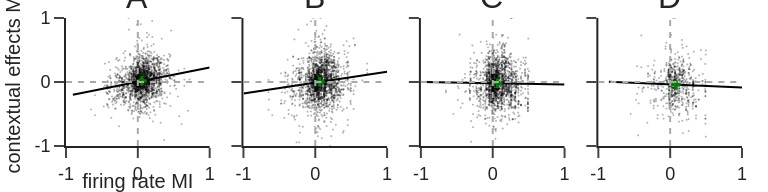

In [8]:
# statistical tests for the regression across all time chunks
chunks = ['A', 'B', 'C', 'D']
fig = make_subplots(1, 4, shared_xaxes=True, shared_yaxes=True,
                    subplot_titles=chunks)

for coln, chunk in enumerate(chunks):
    panelname = f"first_vs_second_order_{chunk}"

    toplot = full_merge.query(f"small_fo > 0.1  and big_fo > 0.1"
                              f" and ((full_so <= -0.3) or (0.3 <= full_so))"
                              f" and chunk == '{chunk}'"
                              ).copy()

    x = toplot['mod_coeff_corrected_fo'].values
    y = toplot['mod_coeff_corrected_so'].values

    ####### statistical tests #######
    print(f'\n###########\nchunk {chunk}, n_neuron={toplot.id.nunique()}, n_instanceses={len(x)}')
    print(f'mean MI: first_ord={x.mean()}, second_ord{y.mean()}')
    # marginal differece from zero
    for marg, vctr in zip(['FR_MI', 'ctx_MI'], [x, y]):
        out = sst.ttest_1samp(vctr, 0)
        print(f'{marg}: {out}')

    # correaltion
    print(f"first vs second order modulation index:"
          f"\n{sst.linregress(x, y)}")

    # main scatter
    xm, ym = decimate_xy(x, y, 2000, by_quantiles=False, rng=np.random.default_rng(42))
    print(len(xm))
    _ = fig.add_trace(go.Scatter(x=xm, y=ym, mode='markers',
                                 marker=dict(size=1,
                                             opacity=0.3,
                                             color='black'),
                                 showlegend=False),
                      row=1, col=coln + 1)

    # interval for unit and regression
    interval = np.asarray([np.min([xm.min(), ym.min()]),
                           np.max([xm.max(), ym.max()])])

    # regression
    reg = sst.linregress(x, y)
    _ = fig.add_trace(go.Scatter(x=interval, y=interval * reg.slope + reg.intercept, mode='lines',
                                 line=dict(dash='solid',
                                           width=1,
                                           color='black'),
                                 showlegend=False),
                      row=1, col=coln + 1)

    # mean marker
    _ = fig.add_trace(go.Scatter(x=[x.mean()],
                                 y=[y.mean()],
                                 mode='markers',
                                 marker=dict(color='green',
                                             size=4,
                                             symbol='cross'),
                                 showlegend=False),
                      row=1, col=coln + 1)

    fig.add_vline(x=0, line=dict(color='darkgray', dash='dot', width=1), opacity=1, row=1, col=coln + 1)
    fig.add_hline(y=0, line=dict(color='darkgray', dash='dot', width=1), opacity=1, row=1, col=coln + 1)

####### Formating #######
w, h = 4, 1
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(l=10, r=10, t=10, b=10))

fig.update_xaxes(tickfont_size=9,
                 range=[-1, 1],
                 tickmode='array',
                 tickvals=[-1, 0, 1],
                 ticktext=[-1, 0, 1],
                 )
fig.update_yaxes(tickfont_size=9,
                 range=[-1, 1],
                 tickmode='array',
                 tickvals=[-1, 0, 1],
                 ticktext=[-1, 0, 1],
                 )

fig.update_xaxes(title=dict(text='firing rate MI',
                            font_size=10, standoff=0),
                 col=1, row=1
                 )
fig.update_yaxes(title=dict(text='contextual effects MI',
                            font_size=10, standoff=0),
                 col=1, row=1,
                 )

filename = folder / 'sup_fig3_first_vs_second_ord_scatter_chunks'
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=2)

## Example PSTHs

In [9]:
# first find an example, the following conditions have to be met
# possitive big first order effects (on full duration)
# possitive big second order effectse (on chunk A)
# big contextual effecs

tosort = full_merge.query("small_fo > 0.1  and big_fo > 0.1"
                          " and ((full_so <= -0.3) or (0.3 <= full_so))"
                          " and mod_coeff_corrected_fo > 0"
                          " and mod_coeff_corrected_so > 0"
                          " and chunk == 'A'").loc[:, ['id', 'context_pair', 'probe',
                                                       'mod_coeff_corrected_fo', 'mod_coeff_corrected_so',
                                                       'T-score_integral']].copy()
tosort['ctx_mod_norm'] = tosort['T-score_integral'] / tosort['T-score_integral'].max()
tosort['euc_dist'] = np.linalg.norm(tosort.loc[:,
                                    ['mod_coeff_corrected_fo',
                                     'mod_coeff_corrected_so',
                                     'ctx_mod_norm']].values,
                                    axis=1)

tosort.sort_values(by='euc_dist', ascending=False, inplace=True, ignore_index=True)
tosort.head()

,id,context_pair,probe,mod_coeff_corrected_fo,mod_coeff_corrected_so,T-score_integral,ctx_mod_norm,euc_dist
0,ARM031a-52-6,03_04,2,0.651578,1.000000,159.083267,0.134336,1.201083
1,TNC019a-031-2,00_08,9,0.506281,1.000000,164.085129,0.138560,1.129389
2,ARM031a-38-3,01_03,3,0.568314,0.935484,72.291389,0.061046,1.096284
3,ARM021b-06-3,00_02,3,0.364405,0.167630,1184.220703,1.000000,1.077446
4,ARM021b-06-3,00_04,3,0.364405,0.174419,1177.375488,0.994220,1.073166


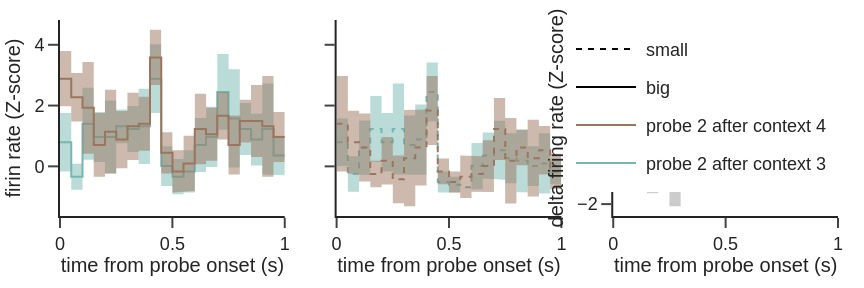

In [10]:
ii = 0
cellid = tosort.loc[ii, 'id']
contexts = [int(cc) for cc in tosort.loc[ii, 'context_pair'].split('_')]
probe = tosort.loc[ii, 'probe']

fig = make_subplots(1, 3, shared_xaxes='all')

# big pupil
f = plot_raw_pair(cellid, contexts, probe, raster_fs=20, colors=TENCOLOR,
                  pupil='big', simplify=True, part='probe')
f.update_traces(line=dict(width=1))
f = f['data']
fig.add_traces(f, cols=[1] * len(f), rows=[1] * len(f))

# small pupil
f = plot_raw_pair(cellid, contexts, probe, raster_fs=20, colors=TENCOLOR,
                  pupil='small', simplify=True, part='probe')
f.update_traces(line=dict(dash='dot', width=1), showlegend=False)
f = f['data']
fig.add_traces(f, cols=[2] * len(f), rows=[1] * len(f))

# delta firing rates
f = plot_pupil_so_effects(cellid, contexts, probe, raster_fs=20)
f.update_traces(line=dict(width=1))

f = f['data']
fig.add_traces(f, cols=[3] * len(f), rows=[1] * len(f))

w, h = 4.5, 1.5
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(l=10, r=10, t=10, b=10),

                  yaxis_title_text='firin rate (Z-score)',
                  yaxis2=dict(matches='y', showticklabels=False),
                  yaxis3=dict(title_text='delta firing rate (Z-score)'),
                  legend=dict(xanchor='right', x=1,
                              yanchor='top', y=1,
                              font_size=9,
                              title=dict(text='')),
                  )

fig.update_xaxes(title=dict(text='time from probe onset (s)', font_size=10, standoff=0),
                 tickfont_size=9)
fig.update_yaxes(title=dict(font_size=10, standoff=0),
                 tickfont_size=9,
                 autorange=True)

filename = folder / 'sup_fig3_psth_examples'
# fig.write_image(filename.with_suffix('.svg'))

fig.show(renderer='jpeg', scale=2)